# Sentence-level relation extraction with classic ML and LLM methods

## Dataset loading and review

In this experiment will be used dataset [SemEval 2010 Task 8](https://paperswithcode.com/dataset/semeval-2010-task-8). This dataset is open-sourced for anyone.

In [2]:
! pip install pandas pyarrow fsspec huggingface_hub spacy scipy sklearn matplotlib networkx transformers datasets torch tqdm

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import networkx as nx
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/SemEvalWorkshop/sem_eval_2010_task_8/" + splits["train"])

In [5]:
df.head()

,sentence,relation
0,The system as described above has its greatest...,3
1,The <e1>child</e1> was carefully wrapped and b...,18
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18
4,The <e1>student</e1> <e2>association</e2> is t...,12


In [6]:
df['sentence'][0]

'The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.'

In [7]:
len(df.relation.unique())

19

There are 19 unique types of relation in this dataset labels:

0 - Cause-Effect(e1,e2)

1 - Cause-Effect(e2,e1)

2 - Component-Whole(e1,e2)

3 - Component-Whole(e2,e1)

4 - Content-Container(e1,e2)

5 - Content-Container(e2,e1)

6 - Entity-Destination(e1,e2)

7 - Entity-Destination(e2,e1)

8 - Entity-Origin(e1,e2)

9 - Entity-Origin(e2,e1)

10 - Instrument-Agency(e1,e2)

11 - Instrument-Agency(e2,e1)

12 - Member-Collection(e1,e2)

13 - Member-Collection(e2,e1)

14 - Message-Topic(e1,e2)

15 - Message-Topic(e2,e1)

16 - Product-Producer(e1,e2)

17 - Product-Producer(e2,e1)

18 - Other


**18 number is used when there is no relation or relation is not of present types**

# Brief task description

Using the **classic ML** method we give the model vectors of features as the input. Model expected to return the predicted class of relations for every item.

Features will be extracted manually with special functions before vectorizing and data splitting.

Vectorizing will be done with TF-IDF-Vectorizer as it's one of the most used classic vectorizers. As the output we expect to have the array of numbers, each showing the relation type for it's sentence.

## Vectorizing with BERT

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
device = torch.device("cpu")

In [10]:
def get_bert_embeddings(sentences, batch_size=32):
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size), desc="Encoding with BERT"):
            batch = sentences[i:i+batch_size]
            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=128
            ).to(device)

            output = bert_model(**encoded)
            cls_embeddings = output.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)

In [11]:
X_bert = get_bert_embeddings(df['sentence'].tolist())

Encoding with BERT: 100%|██████████| 250/250 [03:19<00:00,  1.25it/s]


## Data splitting

In [12]:
y = df['relation']
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

## Model learning and predicting

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
y_pred = clf.predict(X_test)

## Metrics table

In [15]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.786     0.180     0.293        61
           1      0.479     0.500     0.489       138
           2      0.500     0.160     0.242       100
           3      0.466     0.278     0.348        97
           4      0.631     0.466     0.536        88
           5      0.750     0.071     0.130        42
           6      0.459     0.633     0.532       158
           8      0.385     0.093     0.150       107
           9      0.333     0.034     0.062        29
          10      0.000     0.000     0.000        14
          11      0.650     0.153     0.248        85
          12      0.000     0.000     0.000        17
          13      0.390     0.345     0.366       119
          14      0.398     0.340     0.366       103
          15      0.000     0.000     0.000        29
          16      0.000     0.000     0.000        66
          17      1.000     0.011     0.023        87
          18      0.204    

/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Confusion matrix

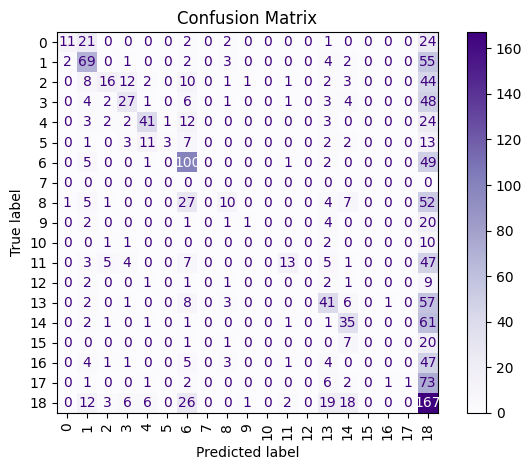

In [16]:
labels = sorted(df['relation'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Purples', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Graph with predicted relations

In [17]:
relation_dict = {
    0: 'Cause-Effect(e1,e2)',
    1: 'Cause-Effect(e2,e1)',
    2: 'Component-Whole(e1,e2)',
    3: 'Component-Whole(e2,e1)',
    4: 'Content-Container(e1,e2)',
    5: 'Content-Container(e2,e1)',
    6: 'Entity-Destination(e1,e2)',
    7: 'Entity-Destination(e2,e1)',
    8: 'Entity-Origin(e1,e2)',
    9: 'Entity-Origin(e2,e1)',
    10: 'Instrument-Agency(e1,e2)',
    11: 'Instrument-Agency(e2,e1)',
    12: 'Member-Collection(e1,e2)',
    13: 'Member-Collection(e2,e1)',
    14: 'Message-Topic(e1,e2)',
    15: 'Message-Topic(e2,e1)',
    16: 'Product-Producer(e1,e2)',
    17: 'Product-Producer(e2,e1)',
    18: 'Other'
}

/var/folders/7h/6f0tx0t91q784vbc4x684d100000gn/T/ipykernel_66867/1119659908.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


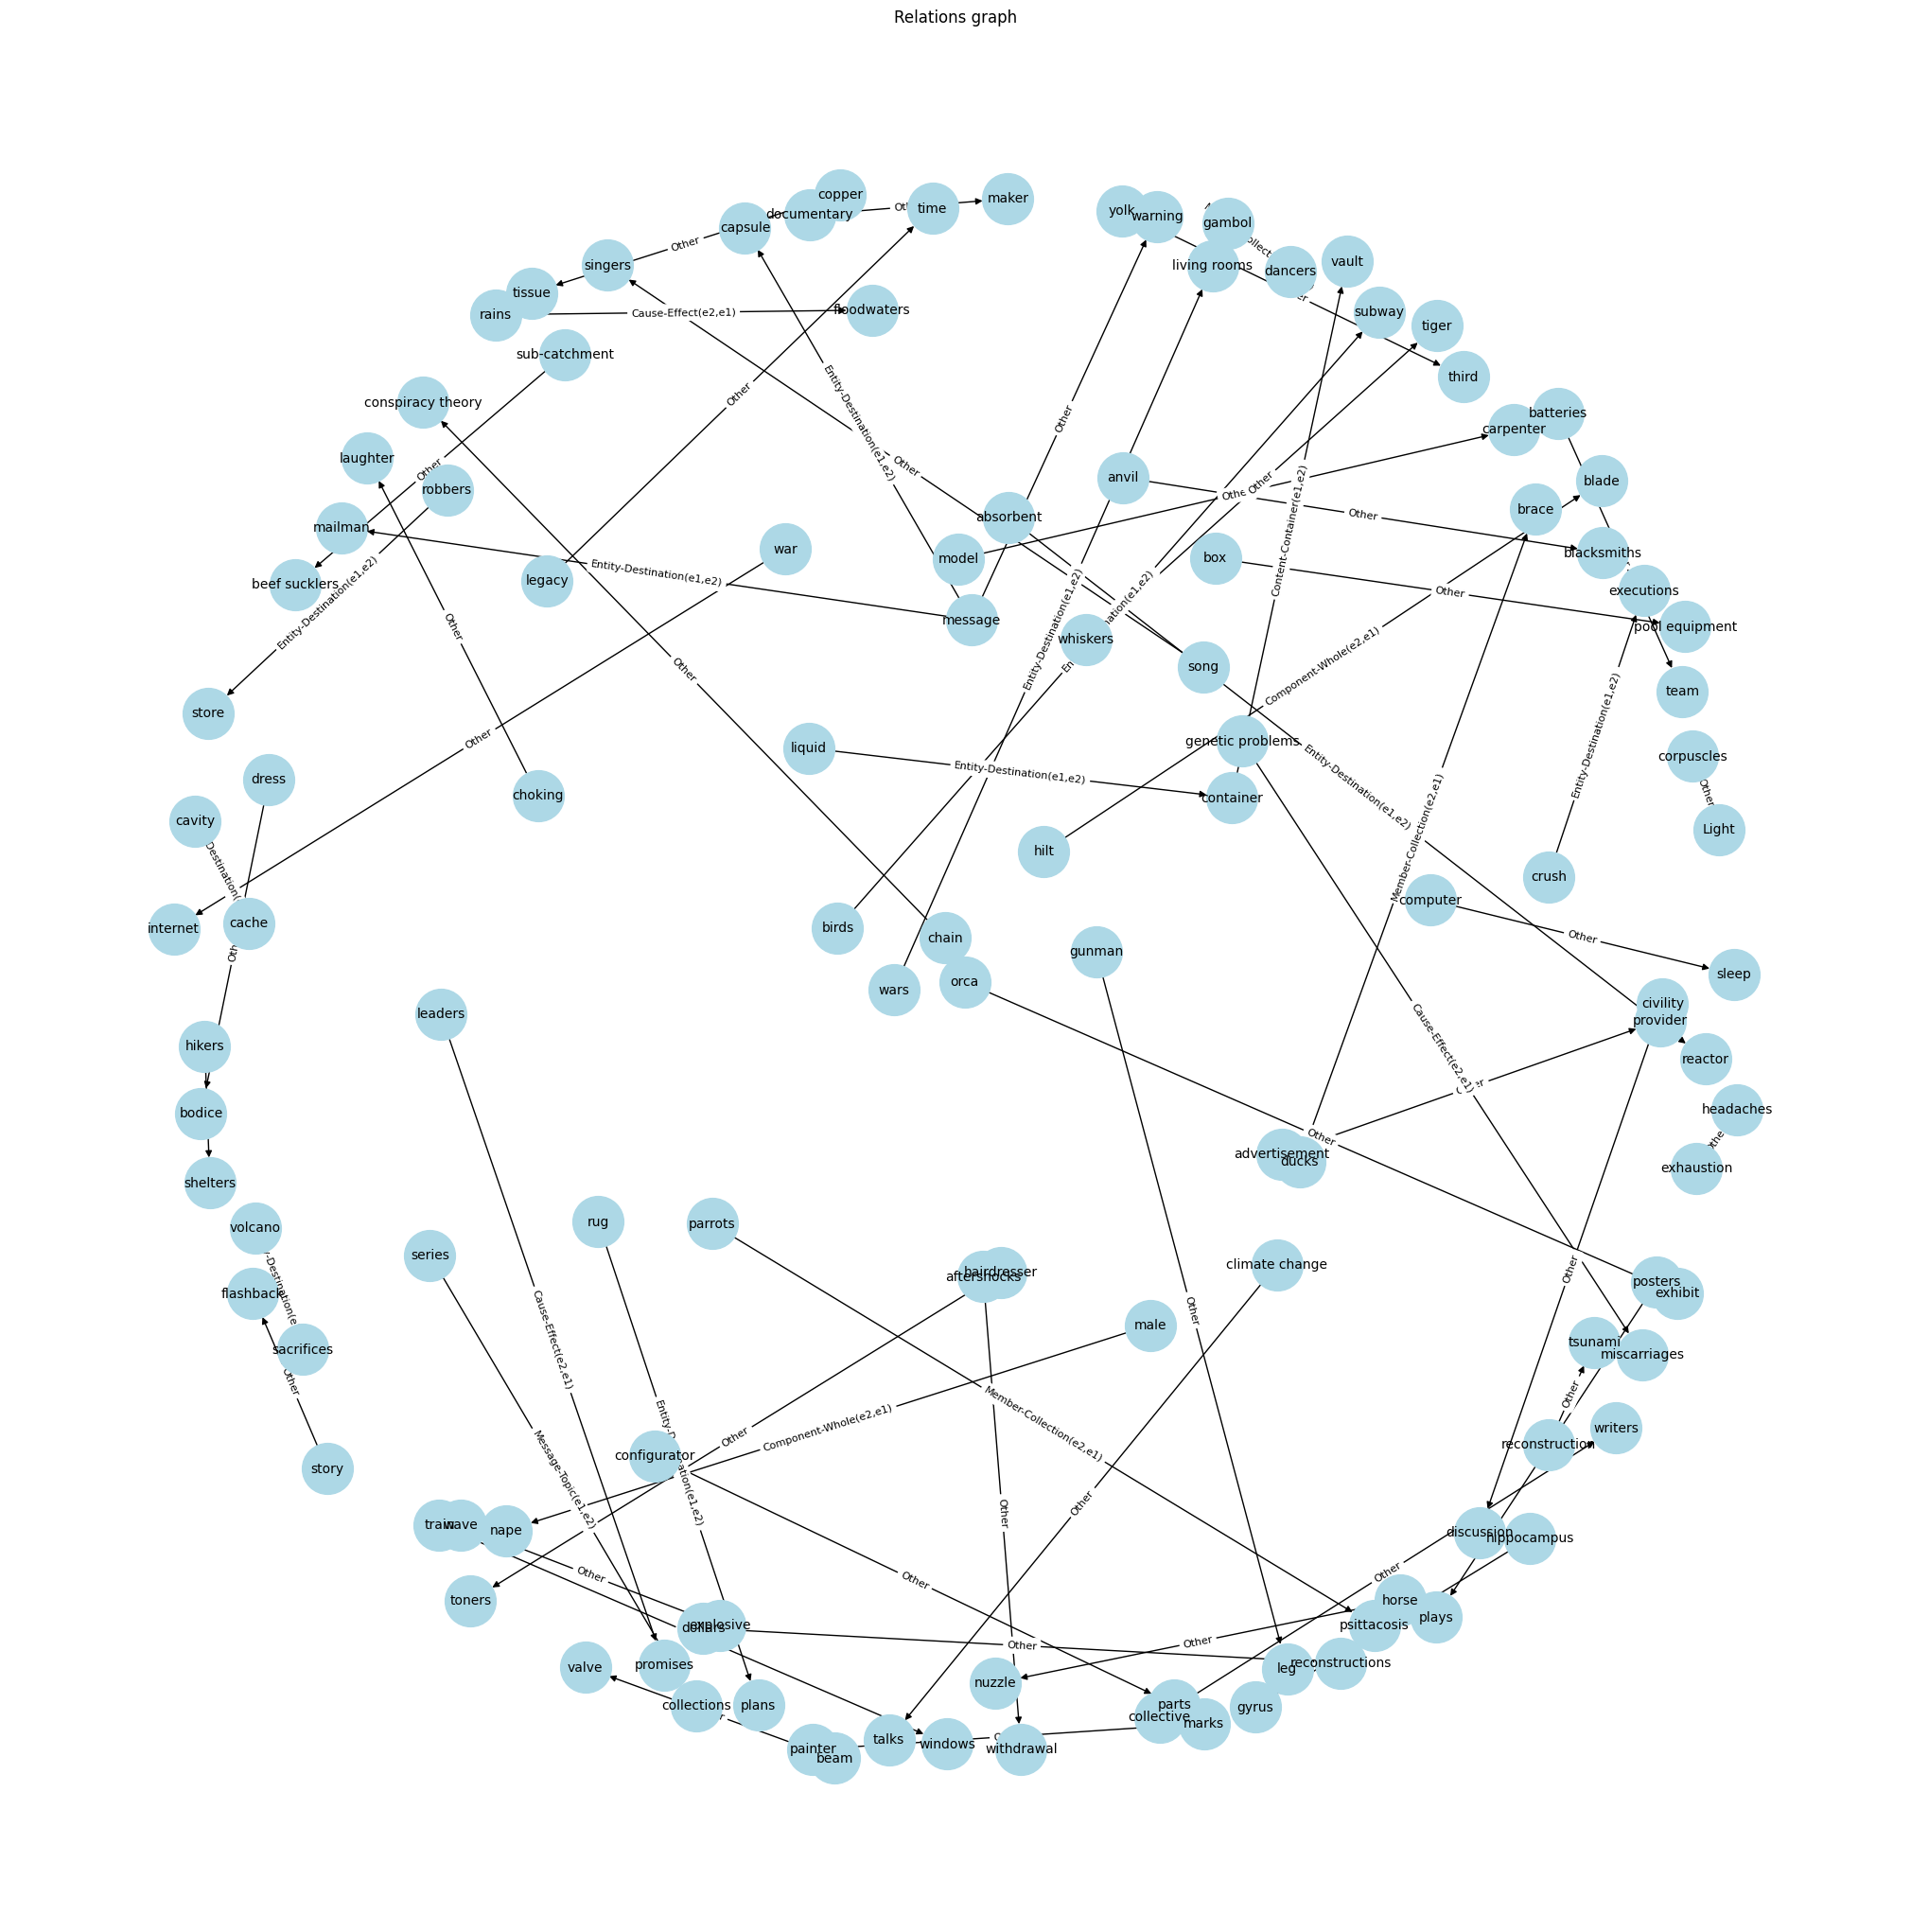

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
G = nx.DiGraph()

for i in range(min(len(df_test), 60)):
    row = df_test.iloc[i]
    pred_label = y_pred[i]
    relation = relation_dict[pred_label]

    sent = row['sentence']
    e1 = sent.split('<e1>')[1].split('</e1>')[0]
    e2 = sent.split('<e2>')[1].split('</e2>')[0]

    if '(e1,e2)' in relation:
        G.add_edge(e1, e2, label=relation)
    elif '(e2,e1)' in relation:
        G.add_edge(e2, e1, label=relation)
    else:
        G.add_edge(e1, e2, label=relation)


plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=1, iterations=100)

nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Relations graph")
plt.tight_layout()
plt.show()